# Calidad del vino JAX

Es el mismo ejercicio que habiamos hecho en clase pero esta vez usando JAX.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Importación de JAX
import jax
import jax.numpy as jnp # Union de numpy con JAX
from jax import grad, jit, random # Compilacion y random de JAX
import optax

# Importación de la funcion de carga del dataset
from sklearn.datasets import load_wine

# Importación para el entrenamiento
from sklearn.model_selection import train_test_split # División de datos
from sklearn.preprocessing import StandardScaler # Escalado de datos
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay # Matriz de confusión

In [19]:
# Cargo los datos
dataset = load_wine()
X = dataset.data
y = dataset.target

In [20]:
# Normalizo los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [21]:
# Divido los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Inicialización de parámetros
def init_params(key, input_dim, output_dim):
    key_w, key_b = random.split(key)
    W = random.normal(key_w, (input_dim, output_dim)) * 0.01
    b = jnp.zeros(output_dim)
    return W, b

In [23]:
# Definición del modelo de red neuronal
def forward(params, X):
    W, b = params
    logits = jnp.dot(X, W) + b
    return logits

In [24]:
# Función de pérdida (Cross-Entropy Loss)
def loss_fn(params, X, y):
    logits = forward(params, X)
    y_one_hot = jax.nn.one_hot(y, logits.shape[1])
    loss = -jnp.mean(jnp.sum(y_one_hot * jax.nn.log_softmax(logits), axis=1))
    return loss

# Gradiente de la función de pérdida
grad_fn = jit(grad(loss_fn))

In [25]:
# Entreno con Optax para que este mas optimizado
key = random.PRNGKey(0)
params = init_params(key, X_train.shape[1], len(jnp.unique(y)))
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(params)

In [26]:
# Método para actualizar los parametros durante el entrenamiento
@jit
def update(params, opt_state, X, y):
    grads = grad_fn(params, X, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

In [27]:
# Entreno el modelo
epochs = 100
for epoch in range(epochs):
    params, opt_state = update(params, opt_state, X_train, y_train)

In [28]:
# Evaluo el modelo
def predict(params, X):
    logits = forward(params, X)
    return jnp.argmax(logits, axis=1)

y_pred = predict(params, X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.4f}')

Precisión del modelo: 0.9722


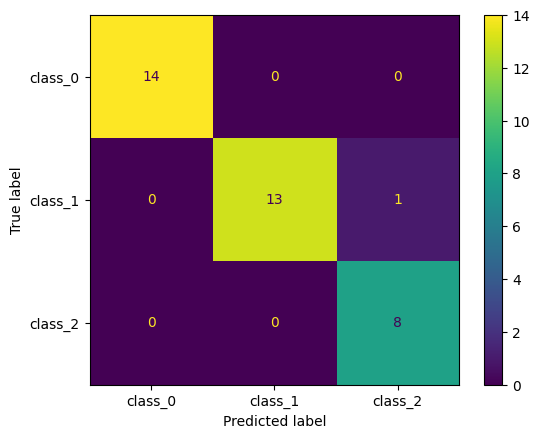

In [29]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=dataset.target_names).plot()
plt.show()